In [13]:
from typing import List

import matplotlib.pyplot as plt
from torchvision import io, transforms
from torchvision.utils import Image, ImageDraw
from torchvision.transforms.functional import to_pil_image
import numpy as np

%matplotlib inline

## import sample image

In [14]:
img = Image.open('data/disease1B_scan/disease1B_scan.png').convert('RGB')
transform = transforms.Compose([
 transforms.ToTensor()
])
img = transform(img)
img.shape

torch.Size([3, 9731, 8843])

#### Channels:	
 - FITC/525 nm : SYTO 13 : DNA (Grey)
 - Cy3/568 nm : Alexa 532 : PanCK (Yellow)
 - Texas Red/615 nm : Alexa 594 : CD45 (Cyan)
 - Cy5/666 nm : Cy5 : Custom (Magenta)

**SYTO** Deep Red Nucleic Acid Stain is cell-permeant dye that specifically stains the nuclei of live, dead, or fixed cells.

**pan-CK** (AE1/AE3) and EMA are epithelium-specific antibodies. As the basic component of cellular structure of normal epithelial cells and epithelial cancer cells, they are often used to differentiate tumors according to whether they originate from the epithelium or not.

**CD45** is a signalling molecule that is an essential regulator of T and B cell antigen receptor signalling.

**CD10+CD31** – Proximal nephrons and endothelial cells (Custom)

In [ ]:
to_pil_image(img)

In [15]:
img = Image.open('data/normal2B_scan/normal2B_scan.png').convert('RGB')
transform = transforms.Compose([
 transforms.ToTensor()
])
img = transform(img)
img.shape

/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (90223056 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


torch.Size([3, 10197, 8848])

In [ ]:
to_pil_image(img)

## image resize

In [16]:
f = 3
IMG_SIZE = 256*f
PATCH_SIZE = 256

resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
resized_img = resize(img)
resized_img.shape

torch.Size([3, 768, 768])

In [ ]:
to_pil_image(resized_img)

## Patches

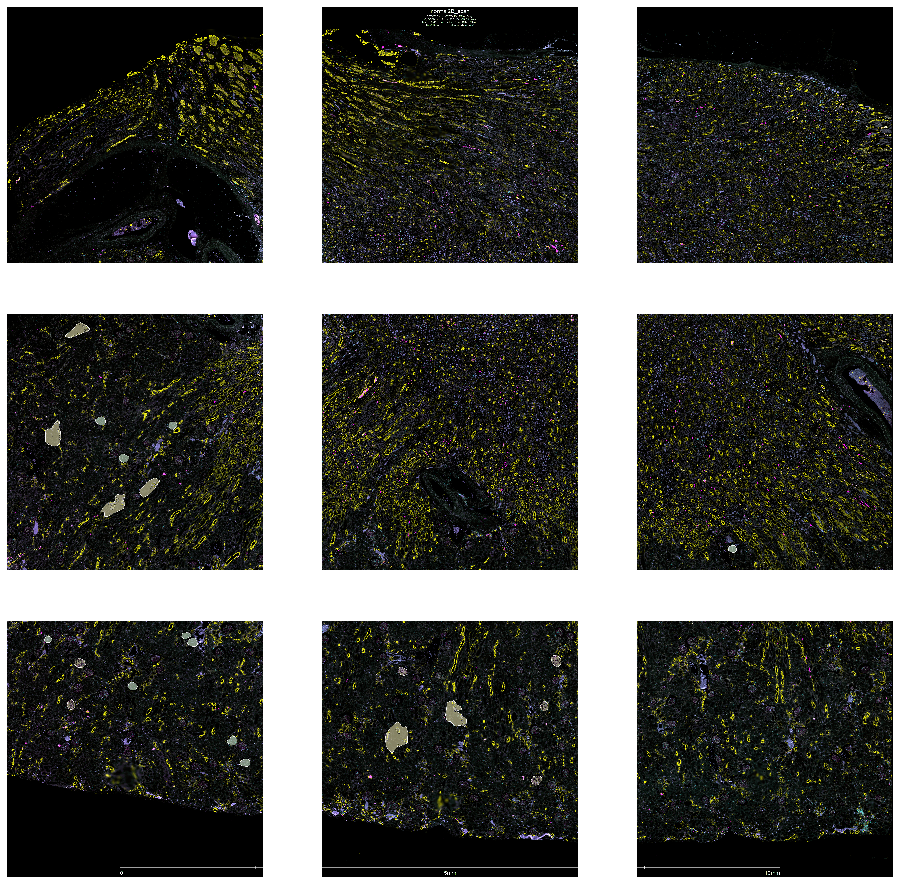

In [17]:
patches = resized_img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)

dataset = []

fig, ax = plt.subplots(f, f, figsize=(16, 16))
for i in range(f):
    for j in range(f):
        sub_img = patches[:, i, j]
        dataset.append(sub_img.unsqueeze(0))
        ax[i][j].imshow(to_pil_image(sub_img))
        ax[i][j].axis('off')

In [18]:
import torch
import torch.nn.functional as F

from PIL import Image

import os
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients
from captum.attr import GradientShap
from captum.attr import Saliency
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

torch.manual_seed(0)
np.random.seed(0)

model = models.resnet50(pretrained=True)
model = model.eval()

In [19]:
!wget -P / https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

--2022-07-21 11:17:35--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.176.93
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.176.93|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘imagenet_class_index.json.11’

magenet_class_index 100%[===================>]  34.53K  --.-KB/s    in 0.09s   

2022-07-21 11:17:35 (396 KB/s) - ‘imagenet_class_index.json.11’ saved [35363/35363]



In [20]:
input = dataset[0]

output = model(input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: American_alligator ( 0.13495555520057678 )


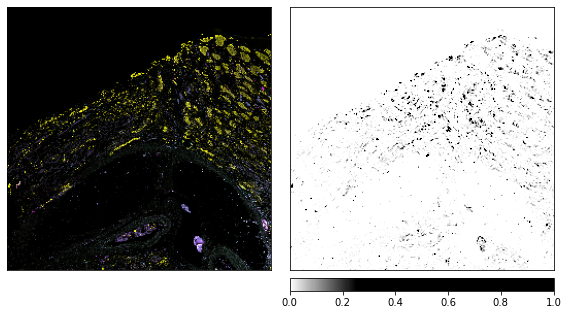

In [21]:
# Create IntegratedGradients object and get attributes
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(input, target=pred_label_idx, n_steps=200)

# create custom colormap for visualizing the result
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)


# visualize the results using the visualize_image_attr helper method
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(input.squeeze().cpu().detach().numpy(), (1,2,0)),
                             methods=["original_image", "heat_map"],
                             signs=['all', 'positive'],
                             cmap=default_cmap,
                             show_colorbar=True)

## train ResNet with trian and validation set of images

In [22]:
def create_datasets(dict_images, n_patches = 9, ref_group = 'normal'):
    PATCH_SIZE = 256
    f = int(np.sqrt(n_patches))
    IMG_SIZE = PATCH_SIZE * f
    resize = transforms.Resize((IMG_SIZE, IMG_SIZE))
    transform = transforms.Compose([
     transforms.ToTensor()
    ])
    
    images = {}
    for group in dict_images.keys():
        dataset = []
        for img in dict_images[group]:
            ## import image
            img = Image.open('data/'+img+'/'+img+'.png').convert('RGB')
            ## convert img to tensor
            img = transform(img)
            ## resize image
            resized_img = resize(img)
            ## create patches
            patches = resized_img.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
            ## reshape data
            for i in range(f):
                for j in range(f):
                    sub_img = patches[:, i, j]
                    if group == ref_group:
                        data_target = (sub_img, 0)
                    else:
                        data_target = (sub_img, 1)
                    dataset.append(data_target)
            images[group] = dataset
    return images

class Custom_Dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, _dataset):
        self.dataset = _dataset

    def __getitem__(self, index):
        example, target = self.dataset[index]
        return example, target

    def __len__(self):
        return len(self.dataset)

In [23]:
train = {'dkd': ['disease1B_scan', 'disease2B_scan'],
         'normal': ['normal2B_scan', 'normal4_scan']}
valid = {'dkd': ['disease3_scan', 'disease4_scan'],
         'normal': ['normal3_scan']}
test = {'dkd': ['disease4_scan'],
        'normal': ['normal4_scan']}

In [24]:
## train loader
train_datasets = create_datasets(dict_images = train, n_patches = 100, ref_group = 'normal')
train_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(train_datasets['dkd'] + train_datasets['normal']),
                                   batch_size=1,
                                   shuffle=False)

## validation loader
valid_datasets = create_datasets(dict_images = valid, n_patches = 100, ref_group = 'normal')
valid_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(valid_datasets['dkd'] + valid_datasets['normal']),
                                   batch_size=1,
                                   shuffle=False)

## test loader
test_datasets = create_datasets(dict_images = test, n_patches = 100, ref_group = 'normal')
test_loader = torch.utils.data.DataLoader(dataset=Custom_Dataset(test_datasets['dkd'] + test_datasets['normal']),
                                   batch_size=1,
                                   shuffle=False)

/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (94257537 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (91075336 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (161360549 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011: DecompressionBombWarning: Image size (121868084 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/Users/asingh/miniconda3/envs/geomx/lib/python3.9/site-packages/PIL/Image.py:3011:

In [25]:
torch.max(train_datasets['dkd'][0][0])

tensor(0.9961)

In [ ]:
from torch import nn, optim

# Hyperparameters
in_channel = 3
num_classes = 2
learning_rate = 1e-3
num_epochs = 10

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(2048, 2)

model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
net = models.resnet18(pretrained=True)
net = net.to(device)
net

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)
net.fc = net.fc.to(device)

n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (valid_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(valid_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')